In [53]:
import pandas as pd
import yfinance as yf
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [54]:
def read_transaction_history(file_path):
    """
    Reads the transaction history from a CSV file and returns a DataFrame.
    """
    return pd.read_csv(file_path, index_col=0)

trans_history = read_transaction_history('TransactionHistory.csv')

In [55]:
def get_time_range(df):
    """
    Extracts and returns the start and end date from a DataFrame.
    """
    # start_date = datetime.strptime(df.iloc[-1, -1], '%m/%d/%Y - %H:%M').strftime('%Y-%m-%d')
    # end_date = datetime.strptime(df.iloc[0, -1], '%m/%d/%Y - %H:%M').strftime('%Y-%m-%d')
    start_date = '2023-01-01'
    end_date = datetime.today().strftime('%Y-%m-%d')
    return start_date, end_date

def calculate_position(df):
    """
    Calculates the final position for each financial instrument.
    """
    return df.groupby(df.index)['Quantity'].sum()

def download_data(tickers, start_date, end_date):
    """
    Downloads financial data for the given tickers and time range.
    """
    return yf.download(tickers, start=start_date, end=end_date, progress=False)

def calculate_value_change(data, positions):
    """
    Calculates the value change for each instrument based on closing and opening prices.
    """
    changes = data['Close'].sub(data['Open'])
    return changes.multiply(positions, axis='columns')

In [56]:
start_date, end_date = get_time_range(trans_history)
final_positions = calculate_position(trans_history)
tickers = trans_history.index.unique().tolist()
financial_data = download_data(tickers, start_date, end_date)
value_change = calculate_value_change(financial_data, final_positions)

# Optional: Save the value change DataFrame to CSV
value_change.to_csv('value_change.csv', index=True)

# Calculate and print the sum of rows
row_sums = value_change.sum(axis=1)
# print(row_sums.tolist())

In [57]:
def calculate_returns(data):
    """
    Calculates the daily returns for the given data.
    """
    return data.pct_change().dropna()

def calculate_beta(asset_returns, market_returns):
    """
    Calculates the beta value of an asset or portfolio relative to the market.
    """
    covariance = asset_returns.cov(market_returns)
    # print(covariance)
    market_variance = market_returns.var()
    # print(market_variance)
    return covariance / market_variance

def calculate_portfolio_value(financial_data, final_positions):
    """
    Calculates the daily total value of the portfolio.
    """
    # 计算每个资产每天的价值
    daily_values = financial_data['Close'] * final_positions
    daily_values = daily_values.dropna()
    # 计算投资组合的每日总价值
    total_value = daily_values.sum(axis=1)
    return total_value

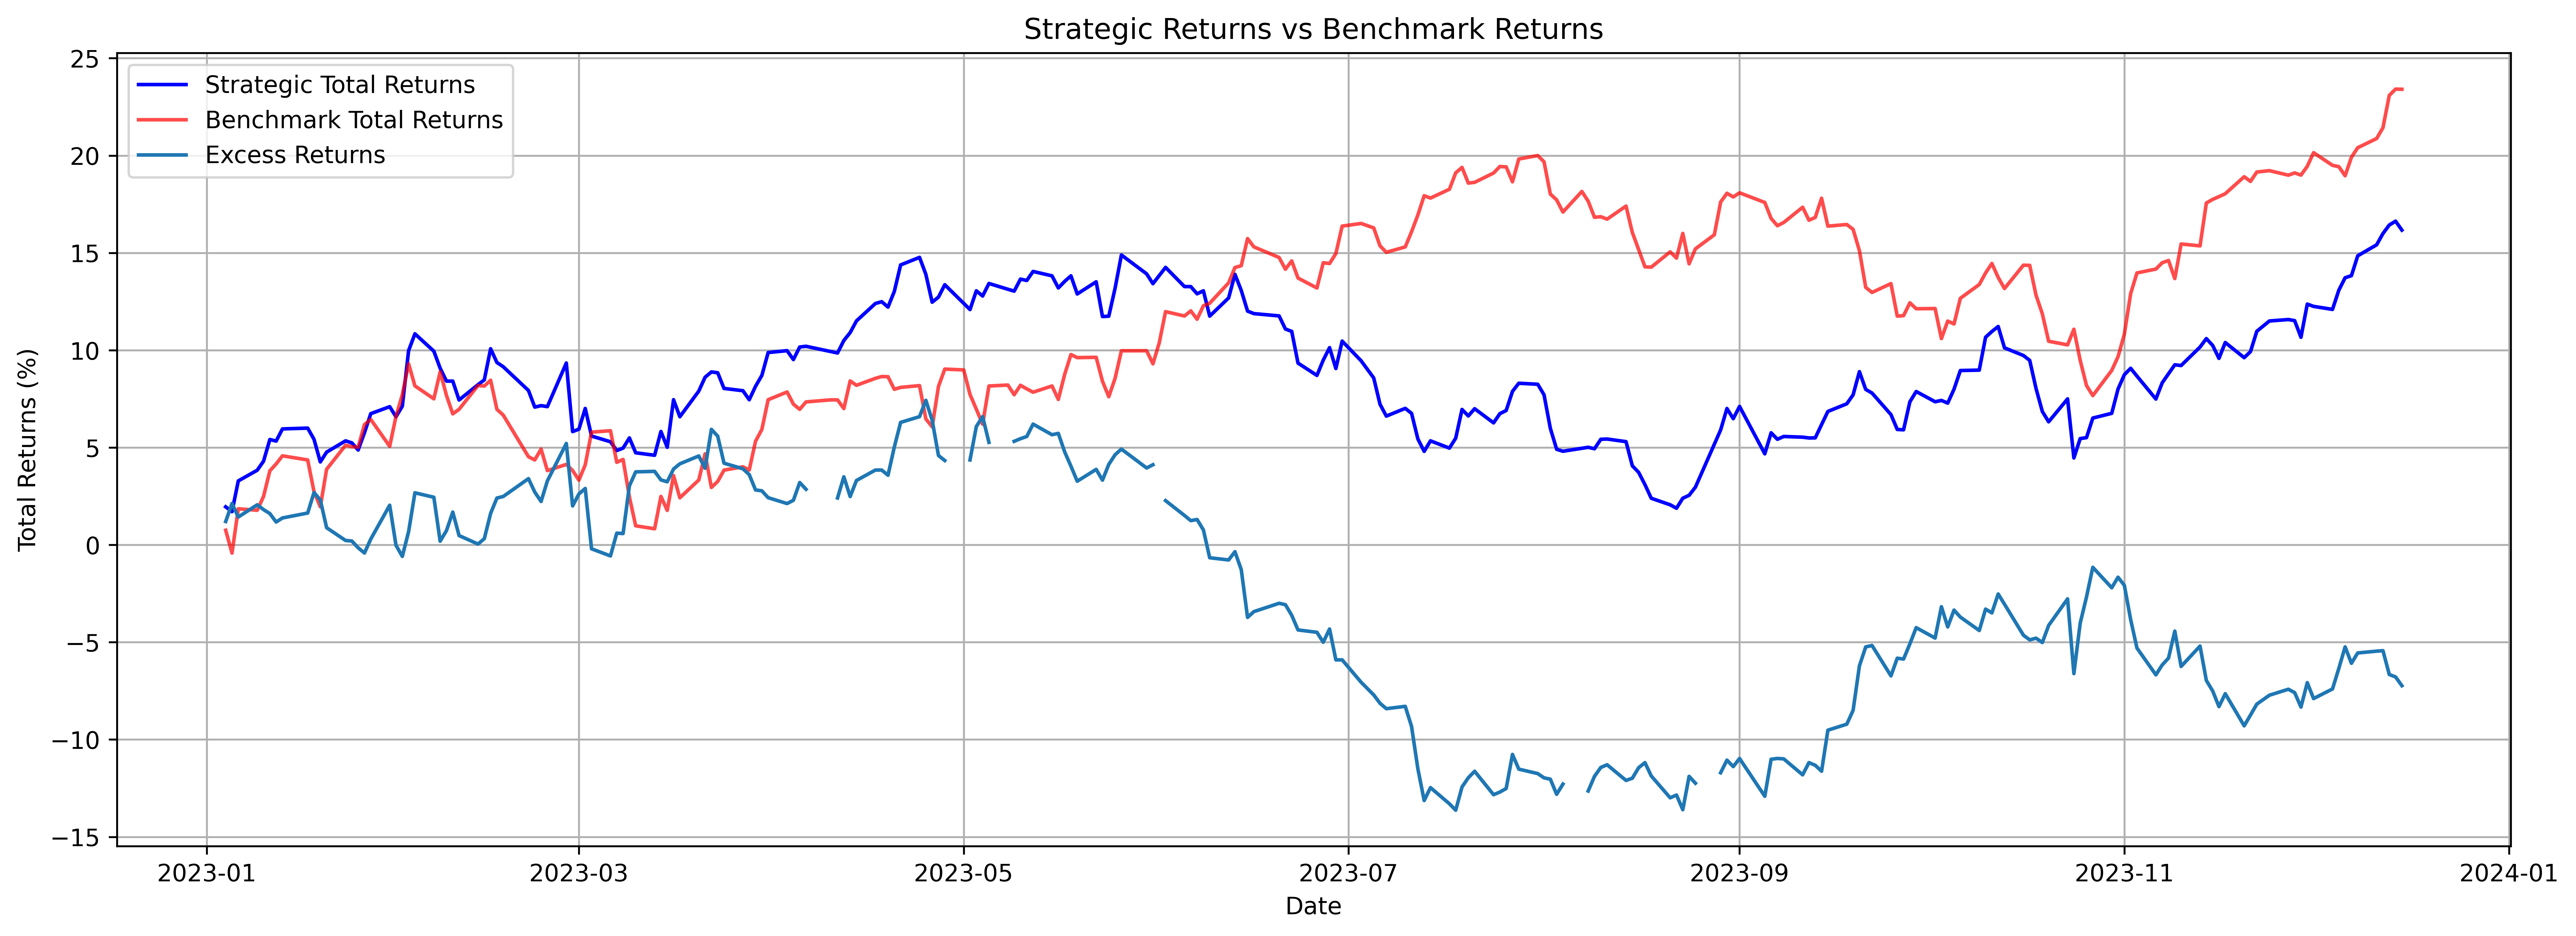

In [58]:
# 计算累积收益
cumulative_returns_portfolio = (1 + portfolio_returns).cumprod()
cumulative_returns_market = (1 + market_returns).cumprod()

# 转换为相对于第一天的百分比变化
cumulative_returns_portfolio_percent = (cumulative_returns_portfolio - 1) * 100
cumulative_returns_market_percent = (cumulative_returns_market - 1) * 100
# 计算超额收益
excess_returns = cumulative_returns_portfolio_percent-cumulative_returns_market_percent

plt.figure(figsize=(18, 6), dpi=600)
plt.plot(cumulative_returns_portfolio_percent.index, cumulative_returns_portfolio_percent, label='Strategic Total Returns', color='blue')
plt.plot(cumulative_returns_market_percent.index, cumulative_returns_market_percent, label='Benchmark Total Returns', alpha=0.7, color='red')
plt.plot(excess_returns.index, excess_returns, label='Excess Returns')
plt.title('Strategic Returns vs Benchmark Returns')
plt.xlabel('Date')
plt.ylabel('Total Returns (%)')
plt.legend()
plt.grid(True)
plt.show()


贝塔值（Beta）是一个衡量投资组合或股票相对于整个市场波动性的指标。
贝塔值的计算公式:

$\beta = \frac{\text{Cov}(r_a, r_m)}{\text{Var}(r_m)}$

贝塔值越大，资产的收益率与市场收益率的相关性越强。

其中：
- $\beta$ 是贝塔值。
- $\text{Cov}(r_a, r_m)$是资产收益率$r_a$和市场收益率$r_m$之间的协方差。
- $\text{Var}(r_m)$ 是市场收益率的方差。

理想值:
- 如果 $\beta = 1$，则表明该资产的价格波动与市场平均水平相同。
- 如果 $\beta > 1$，则表明资产比市场更有波动性（更具风险性）。
- 如果 $\beta < 1$，则表明资产的波动性小于市场。


In [59]:
# Download S&P 500 Index data for the same time range
market_data = download_data(['^GSPC'], start_date, end_date)
market_returns = calculate_returns(market_data['Close'])

# Calculate the portfolio's returns
portfolio_returns = calculate_returns(value_change.sum(axis=1))
portfolio_returns = portfolio_returns[1:]

# 重新计算投资组合的每日总价值和收益率
portfolio_total_value = calculate_portfolio_value(financial_data, final_positions)
portfolio_returns = portfolio_total_value.pct_change().dropna()

# 计算贝塔值
portfolio_beta = calculate_beta(portfolio_returns, market_returns)
print("Portfolio Beta:", portfolio_beta)


Portfolio Beta: 0.38983226848390024


**阿尔法的计算公式：**

$text{Alpha} = R_p - (R_f + \beta \times (R_m - R_f))$

其中：

- $R_p$ 是投资组合的实际年化收益率。
- $R_f$ 是无风险收益率。
- $\beta$ 是投资组合相对于基准的贝塔值。
- $R_m$ 是市场基准的年化收益率。

阿尔法值表示投资组合超过（或低于）基于其风险水平所预期的市场回报的程度。正阿尔法值意味着投资表现超过了其贝塔所预测的回报，而负阿尔法值则意味着表现低于预期。


In [60]:
# 假设的年交易日数
annual_trading_days = 252
# 计算平均日收益率
average_daily_return = portfolio_returns.mean()
# 年化收益率
annualized_return = (1 + average_daily_return) ** annual_trading_days - 1
# 计算市场基准的平均日收益率
average_daily_market_return = market_returns.mean()
# 年化市场基准收益率
annualized_market_return = (1 + average_daily_market_return) ** annual_trading_days - 1
# 无风险利率
risk_free_rate = 0.0505  # 根据您之前的描述
# 计算阿尔法
alpha = annualized_return - (risk_free_rate + portfolio_beta * (annualized_market_return - risk_free_rate))
print("投资策略的阿尔法: {:.4f}".format(alpha))

投资策略的阿尔法: 0.0541


In [61]:
# 假设的年交易日数
annual_trading_days = 252

# 计算日收益率的标准差（波动率）
portfolio_volatility = portfolio_returns.std()
benchmark_volatility = market_returns.std()

# 年化波动率
annualized_portfolio_volatility = portfolio_volatility * (annual_trading_days ** 0.5)
annualized_benchmark_volatility = benchmark_volatility * (annual_trading_days ** 0.5)

print("投资策略的年化波动率: {:.4%}".format(annualized_portfolio_volatility))
print("基准的年化波动率: {:.4%}".format(annualized_benchmark_volatility))

投资策略的年化波动率: 13.2243%
基准的年化波动率: 13.1975%


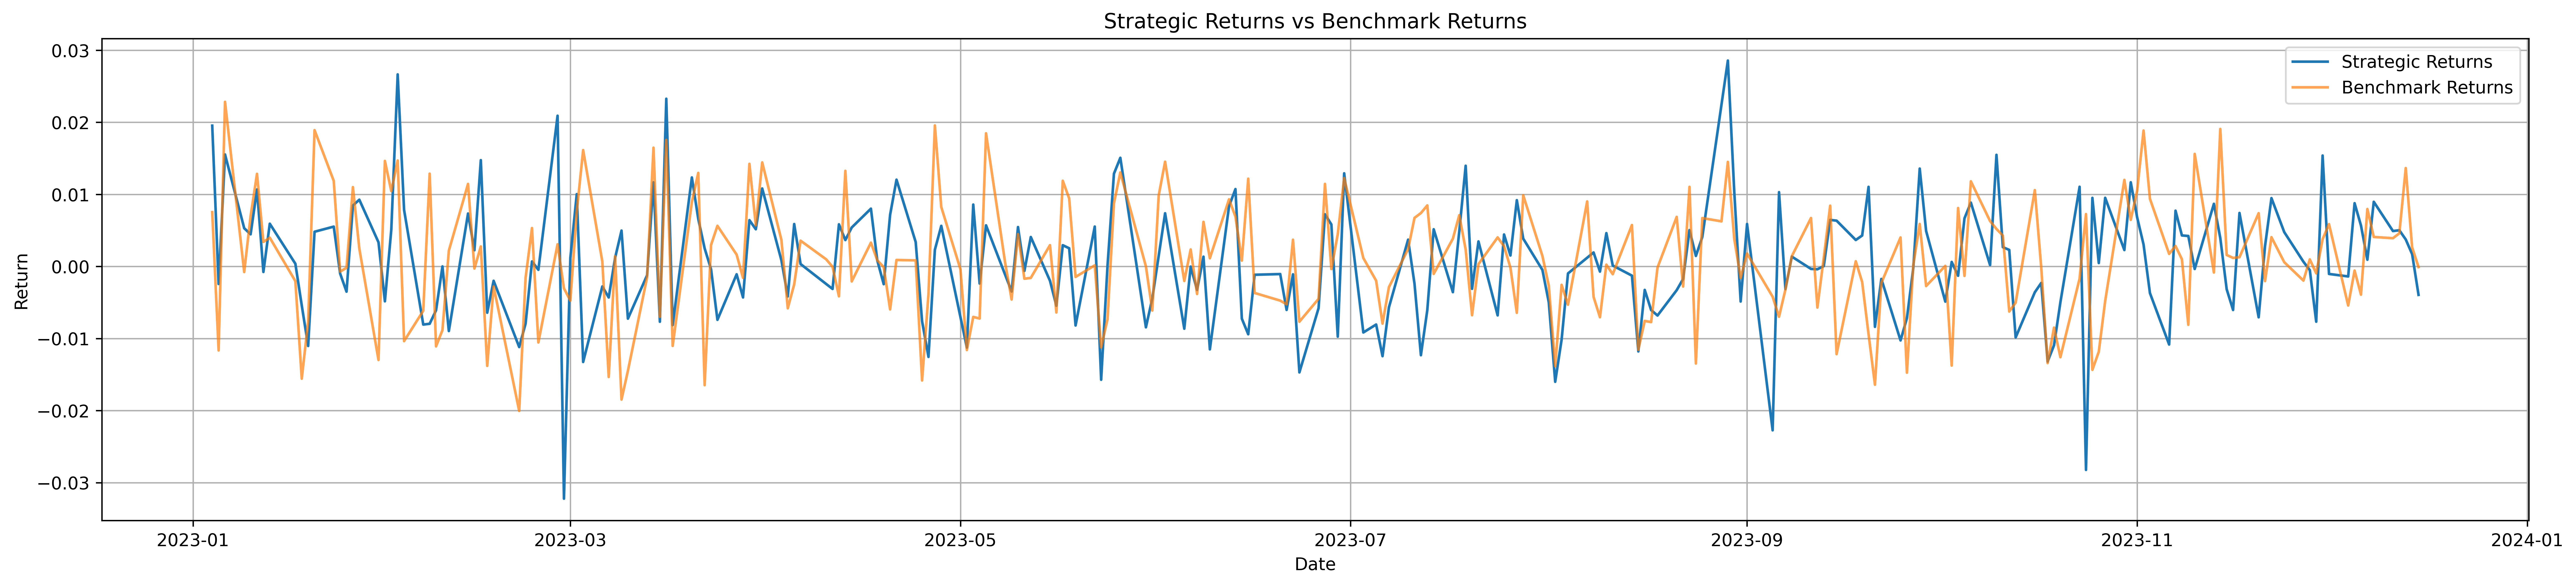

In [62]:
plt.figure(figsize=(25, 5), dpi=600)
plt.plot(portfolio_returns.index, portfolio_returns, label='Strategic Returns')
plt.plot(market_returns.index, market_returns, label='Benchmark Returns', alpha=0.7)
plt.title('Strategic Returns vs Benchmark Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.show()

夏普比率（Sharpe Ratio）是衡量投资绩效的一个重要指标，它通过比较投资的超额收益（相对于无风险收益率）和投资的总风险（标准差）来计算。

夏普比率的计算公式如下：

$\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}$

其中：

- $R_p$ 是投资组合的预期收益率。
- $R_f$是无风险收益率。
- $\sigma_p$ 是投资组合的标准差（风险）。

夏普比率的解释：

- 如果夏普比率是正值，表示投资组合在扣除无风险收益后仍有正收益。
- 如果夏普比率是负值，表示投资组合的表现不如无风险投资。
- 一般来说，夏普比率越高，表示投资组合单位风险的收益越高，投资效率越好。


例如，如果有日收益率数据，夏普比率的计算方法如下：

$\text{Sharpe Ratio} = \frac{(平均日收益率 - 无风险日收益率) \times 252}{\text{日收益率标准差} \times \sqrt{252}}$

p.s. 252为一年交易日数量。无风险收益率使用 *美国联邦基金利率*。

In [63]:
def sharpe_ratio_calculator(portfolio_returns, annual_trading_days=252, risk_free_rate=0.0505):
    # 计算日收益率的平均值
    average_daily_return = portfolio_returns.mean()
    # 计算日收益率的标准差
    daily_std_dev = portfolio_returns.std()
    # 年化收益率
    annualized_return = (1 + average_daily_return) ** annual_trading_days - 1
    # 年化标准差
    annualized_std_dev = daily_std_dev * (annual_trading_days ** 0.5)
    # 计算夏普比率
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std_dev
    # print(sharpe_ratio)
    return sharpe_ratio
sharpe_ratio_calculator(portfolio_returns)

1.0204606362853825

索提诺比率（Sortino Ratio）是一个类似于夏普比率的风险调整性能指标，但它只关注投资组合的下行风险，而不是总体波动性。索提诺比率通常用于评估投资组合在面对不利市场条件时的表现。

索提诺比率的计算公式：

$\text{Sortino Ratio} = \frac{R_p - R_f}{\sigma_d}$

其中：

- $R_p$ 是投资组合的预期收益率。
- $R_f$ 是无风险收益率。
- $\sigma_d$ 是投资组合下行波动性的标准差（仅考虑收益率低于平均水平的情况）。

In [64]:
def sortino_ratio_calculator(portfolio_returns, annual_return=0.06, risk_free_rate=0.0505):
    # 计算下行波动性
    # 首先计算投资组合日收益率低于平均值的收益率
    negative_returns = portfolio_returns[portfolio_returns < portfolio_returns.mean()]
    # 计算这些负收益率的标准差
    downside_std_dev = np.std(negative_returns)
    # 计算索提诺比率
    sortino_ratio = (annual_return - risk_free_rate) / downside_std_dev
    return sortino_ratio

sortino_ratio_calculator(portfolio_returns, annual_return=0.07)

3.5600983896422083

In [68]:
# 计算每日累积收益
cumulative_returns = (1 + portfolio_returns).cumprod()

# 计算每个时间点的累积最大收益
cumulative_max = cumulative_returns.cummax()

# 计算回撤
drawdown = cumulative_max - cumulative_returns

# 计算最大回撤
max_drawdown = drawdown.max()

# 找出最大回撤的时间范围
end_date = drawdown.idxmax()  # 最大回撤结束的时间
start_date = cumulative_returns[:end_date].idxmax()  # 最大回撤开始的时间

print("最大回撤: {:.2%}".format(max_drawdown))
print("最大回撤时间范围: {} 至 {}".format(start_date.date(), end_date.date()))

最大回撤: 13.01%
最大回撤时间范围: 2023-05-26 至 2023-08-22


In [69]:
# 计算每日累积收益
cumulative_returns = (1 + excess_returns).cumprod()

# 计算每个时间点的累积最大收益
cumulative_max = cumulative_returns.cummax()

# 计算回撤
drawdown = cumulative_max - cumulative_returns

# 计算最大回撤
max_drawdown = drawdown.max()

# 找出最大回撤的时间范围
end_date = drawdown.idxmax()  # 最大回撤结束的时间
start_date = cumulative_returns[:end_date].idxmax()  # 最大回撤开始的时间

print("超额收益最大回撤: {:.2%}".format(max_drawdown))
print("超额收益最大回撤时间范围: {} 至 {}".format(start_date.date(), end_date.date()))


超额收益最大回撤: 936474257839815902571280915831858132217562763024430623817118468626756779916132276291936313014546515767816069413674530956928835530526201489075013156864.00%
超额收益最大回撤时间范围: 2023-12-14 至 2023-12-15


**信息比率计算公式**

$\text{Information Ratio} = \frac{R_p - R_b}{\sigma_{(R_p - R_b)}}$

其中：

- $\R_p$ 是投资组合的收益率。
- $\R_b$ 是基准的收益率。
- $\sigma_{(R_p - R_b)}$是超额收益的标准差，即投资组合收益率和基准收益率差异的标准差。


In [67]:
# 计算超额收益的标准差
excess_return_std_dev = excess_returns.std()

# 计算信息比率
information_ratio = excess_returns.mean() / excess_return_std_dev

print("信息比率: {:.4f}".format(information_ratio))


信息比率: -0.4829
